In [1]:
#for evaluate

In [ ]:
'''
실험은 여기서 진행하면 될거야
원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고
최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면
그 때 만들어도 될 것 같다.

필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼
그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고
'''

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# cd [your src path]
%cd /content/drive/MyDrive/bistelligence/BISTelligence/src

/content/drive/MyDrive/bistelligence/BISTelligence/src


In [ ]:
%pip install pyod tensorflow shap

In [6]:
from sklearn.utils.validation import check_is_fitted
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import shap
     
import data.preprocessing as dp
import model.models as mm
import XAI.xai as xx

In [7]:
path = '/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv'
train_data, test_data = 0, 0
threshold = 0

trainer = mm.ModelTrain()

In [8]:
def SetData(scaled=True, key_num = -1):
  global train_data, test_data

  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

In [9]:
def GetModel(model_name='MCD', param_dict={}):
  '''
  [default value in 'ModelTrain' Class]
  param_dict={'contamination':0.01,
                     'nu':0.01,
                     'novelty':True,
                     'random_state':42,
                     'n_conponents':1,
                     'cv_type':'full',
                     'momentum':0.9,
                     'learning_rate':0.03,
                     'epochs':100,
                     'patience':10}
  '''

  global trainer

  trainer.SetTrainer(train_data)
  trainer.SetParam(param_dict)
  model = trainer.GetTrainedModel(model_name)

  return model

In [10]:
def GetAnomalyScore(model=None):
  '''
  모델의 anomaly score return

  나중에 웹이나 시각화 툴로 health index 나타낼 때, (x,y)값 입력해야하는 경우 필요할 것 같아서 만듦.
  혹시 필요 없더라도 문제 없으니까 구현
  '''

  if check_is_fitted(model) == None:
    model_name = type(model).__name__

  if model_name == 'MCD':
    anomaly_score = model.decision_function(test_data)

  elif model_name in ['LocalOutlierFactor','GaussianMixture']:
    anomaly_score = -model.score_samples(test_data)

  elif model_name == 'OneClassSVM':
    anomaly_score = np.max(model.decision_function(test_data))-(model.decision_function(test_data))

  elif model_name == 'IsolationForest':
    anomaly_score = np.max(model.score_samples(test_data))-(model.score_samples(test_data))

  else:
    reconstruction = model.predict(test_data)
    mse = np.mean(np.power(test_data-reconstruction,2),axis=1)
    anomaly_score = ss.zscore(mse)

  return anomaly_score

In [11]:
def ShowHealthIndex(model = None, anomaly_score = None, scaled = True, key_num = 123456):
  '''
  GetAnomalyScore로 이상치 점수 받아온 후, health index plot을 도출
  png로 저장 혹은 단순 plot 도출
  '''
  #plt.rcParams['figure.figsize'] = (12, 8)
  model_name = type(model).__name__
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
  sns.scatterplot(range(len(anomaly_score)), anomaly_score)
  plt.title('{} health index in key {} '.format(model_name, key_num ,scaled), fontsize = 25)
  #plt.show()

In [12]:
def SetThreshold(scaled = True):
  '''
  threshold는 eda plot을 통해 임의로 정한 상태(scale/non scale별로 상이하게 정할 수 있게 함)
  '''
  global threshold

  model_name = type(model).__name__
  if model_name == 'MCD':
    if (scaled):
      threshold = 100
    else:
      threshold = 100
  elif model_name in 'LocalOutlierFactor':
    if (scaled):
      threshold = 2
    else:
      threshold = 2
  elif model_name in 'OneClassSVM':
    if (scaled):
      threshold = 0.05
    else:
      threshold = 0.005
  elif model_name in 'GaussianMixture':
    if (scaled):
      threshold = 100
    else:
      threshold = 100
  elif model_name in 'IsolationForest':
    if (scaled):
      threshold = 0.05
    else:
      threshold = 0.005
  else:
    if (scaled):
      threshold = 2
    else:
      threshold = 2

In [13]:
def DoXAI(model = None):
  '''
  더 잘맞는 함수 이름으로 바꿔도 괜찮고, 파라미터도 상황에 맞게 변경 가능
  (threshold를 입력받아야 XAI가 진행될 수도 있다고 생각되는데 그럴 경우, SetThreshold() 함수를 만들어서 threshold에 값 저장시킬 필요 있음.)
  XAI 폴더의 xai.py(가명)의 함수들을 실행시키는 함수
  
  xai.py(가명)의 함수들은 shap에서 지원하는 여러가지 plot을 그리고, png 파일로 XAI 폴더 내에 저장하는 동작으로 가정
  따라서 DoXAI()를 실행하면 XAI 폴더 내에 여러 plot png파일이 생성되는것을 생각하고 만듦
  '''
  score = GetAnomalyScore(model)
  SetThreshold()
  shap_values_all = xx.XAIModels(model).novelty_contribution(train_data, test_data, score, threshold)
  shap.summary_plot(shap_values_all.values, shap_values_all.columns, plot_type = "bar", show=False)
  plt.tight_layout()
  plt.show()

In [14]:
def SaveBestModel(model):
  # model.saved_model 폴더에 모델 저장
  %cd /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model
  filename = '_'.join(['best', type(model).__name__])
  joblib.dump(model, filename)

In [15]:
def LoadBestModel(model):
  %cd /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model
  filename = '_'.join(['best', type(model).__name__])
  model = joblib.load(filename)
  return model

> **MCD**

마할라노비스 거리, 계산 기반이라 contamination이 score에 영향 x
정상 데이터만 학습하기 때문에 support_fraction 조절 x

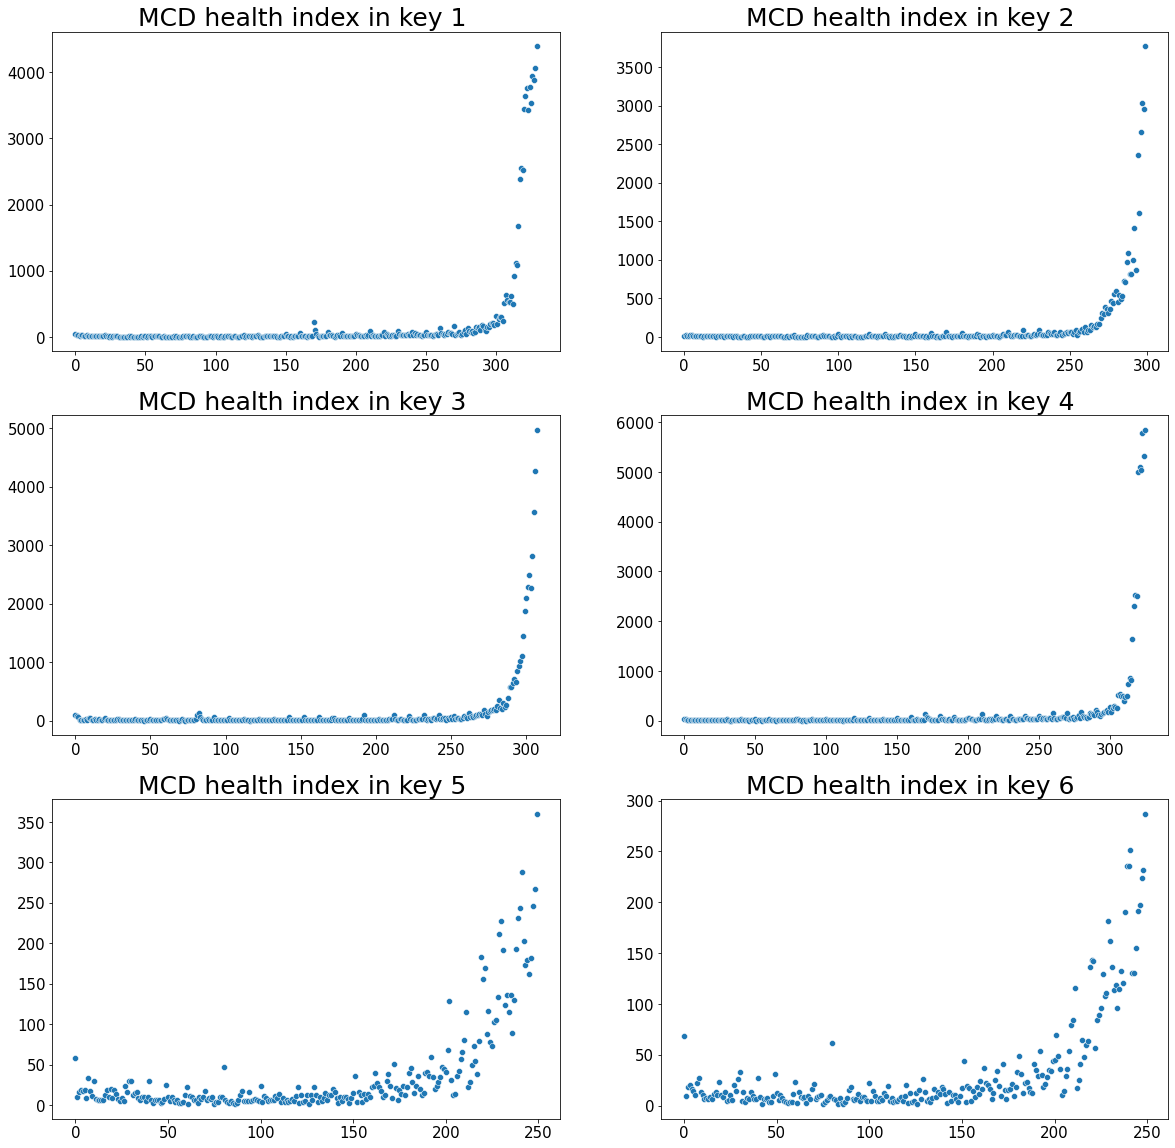

In [16]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

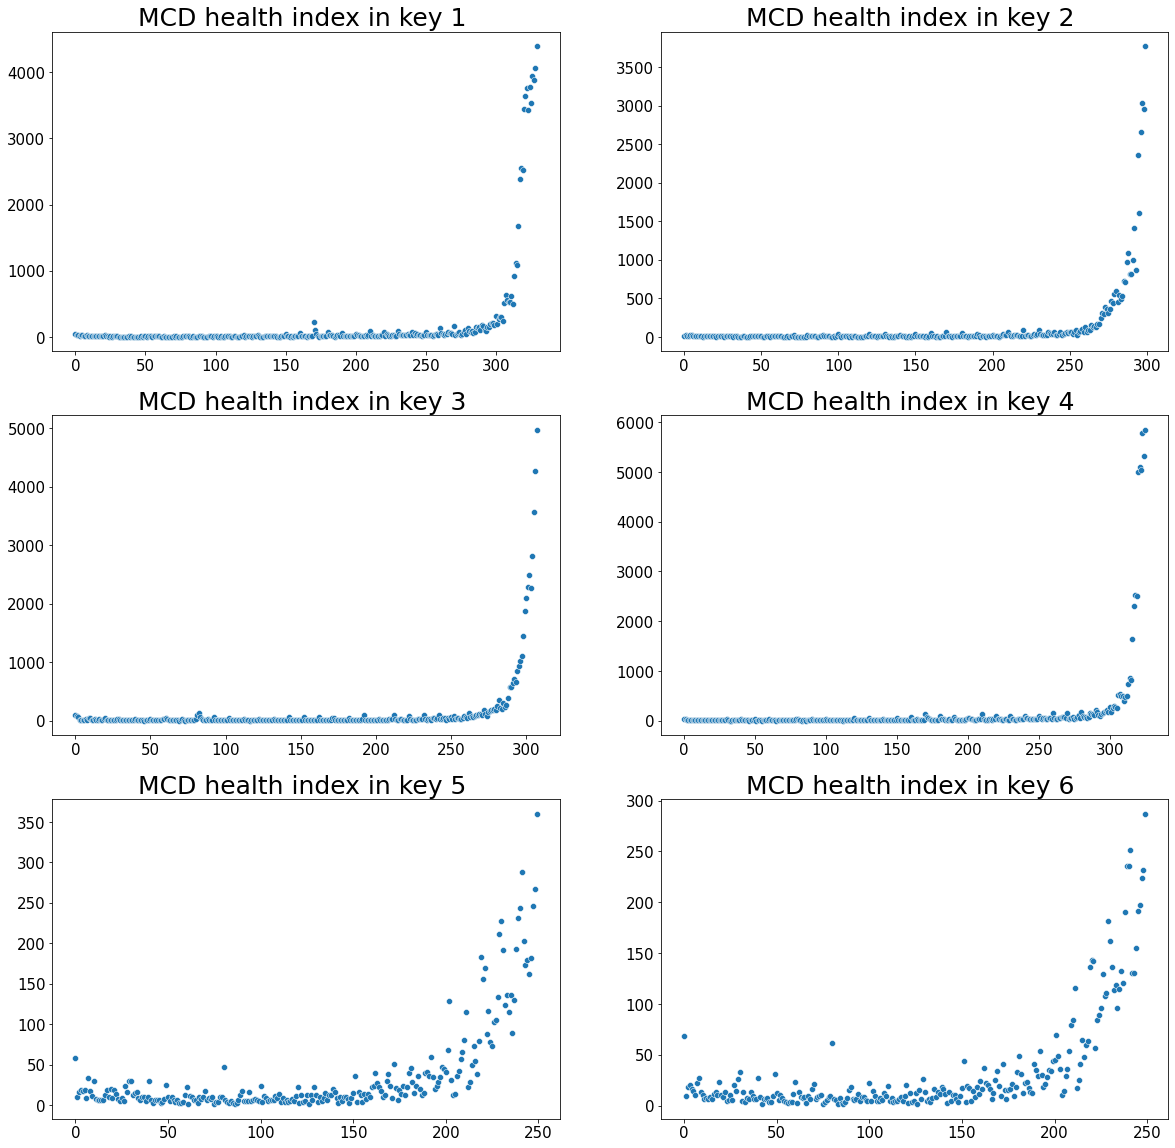

In [17]:
# scale X
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

> **LOF**

LocalOutlierFactor(contamination=0.01, novelty=True)


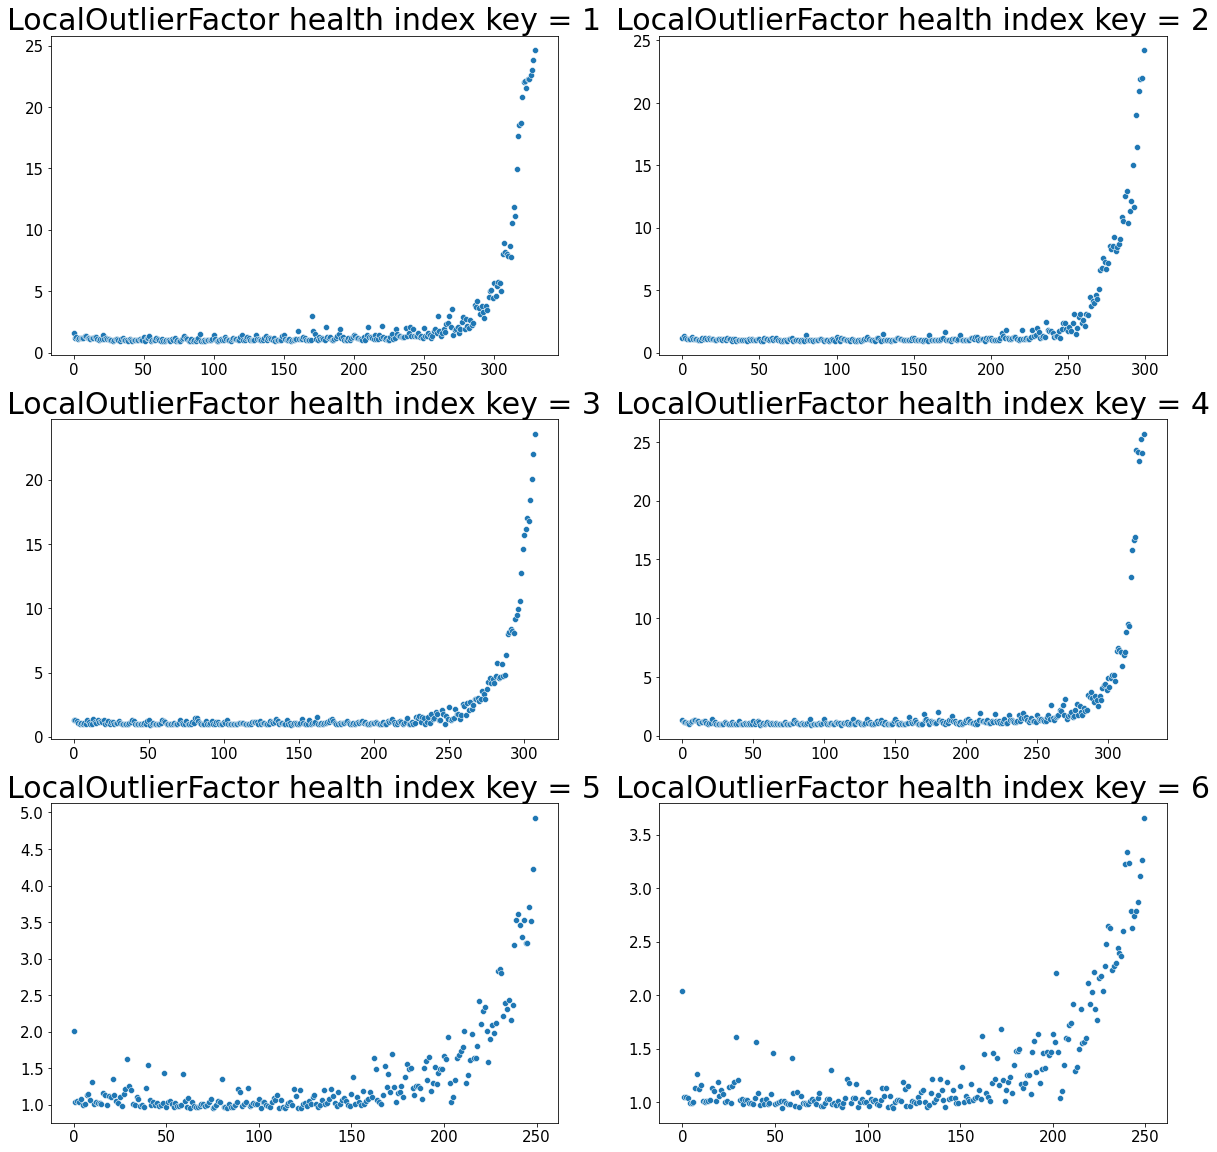

In [18]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'LOF',param_dict = {'n_neighbors':30})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

LocalOutlierFactor(contamination=0.01, novelty=True)


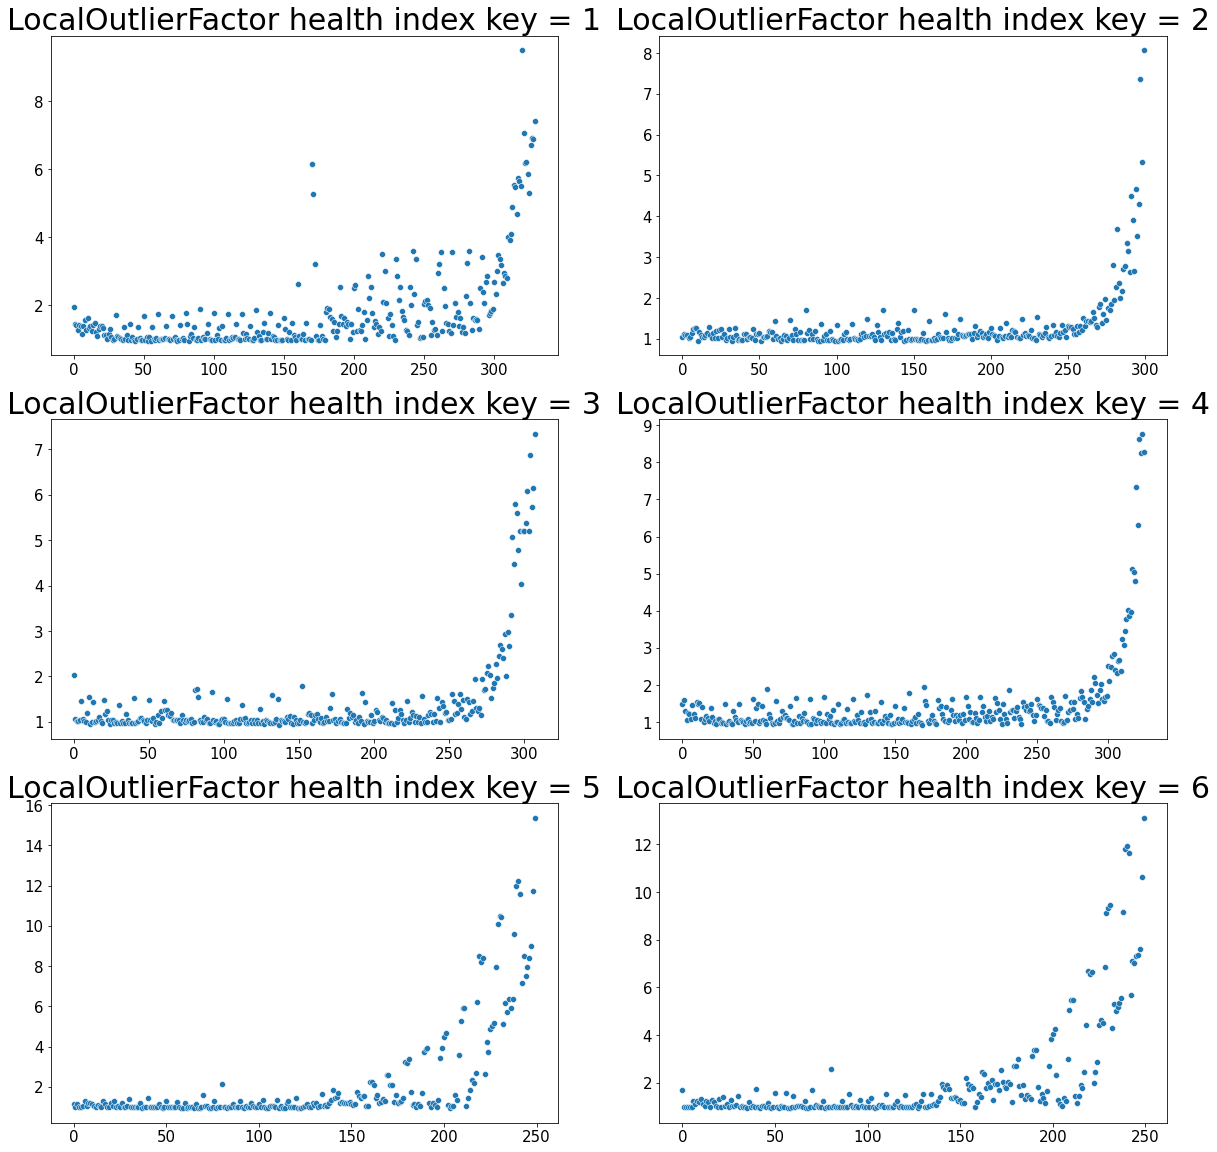

In [19]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'LOF', param_dict = {'n_neighbors': 30, 'contamination': 0.01})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

> **OCSVM**

scaling 후 ocsvm에서 이상 데이터의 점수가 거의 비슷한 것을 볼 수 있다. ocsvm의 decision function이 hyperplane을 기준으로 각 관측치 까지의 거리 값을 출력하는 것을 고려하면 scaling으로 인해 이러한 결과를 보이는것 같음
ocsvm은 scaling이 부적절하다고 생각
kernel은 rbf

OneClassSVM(nu=0.01)


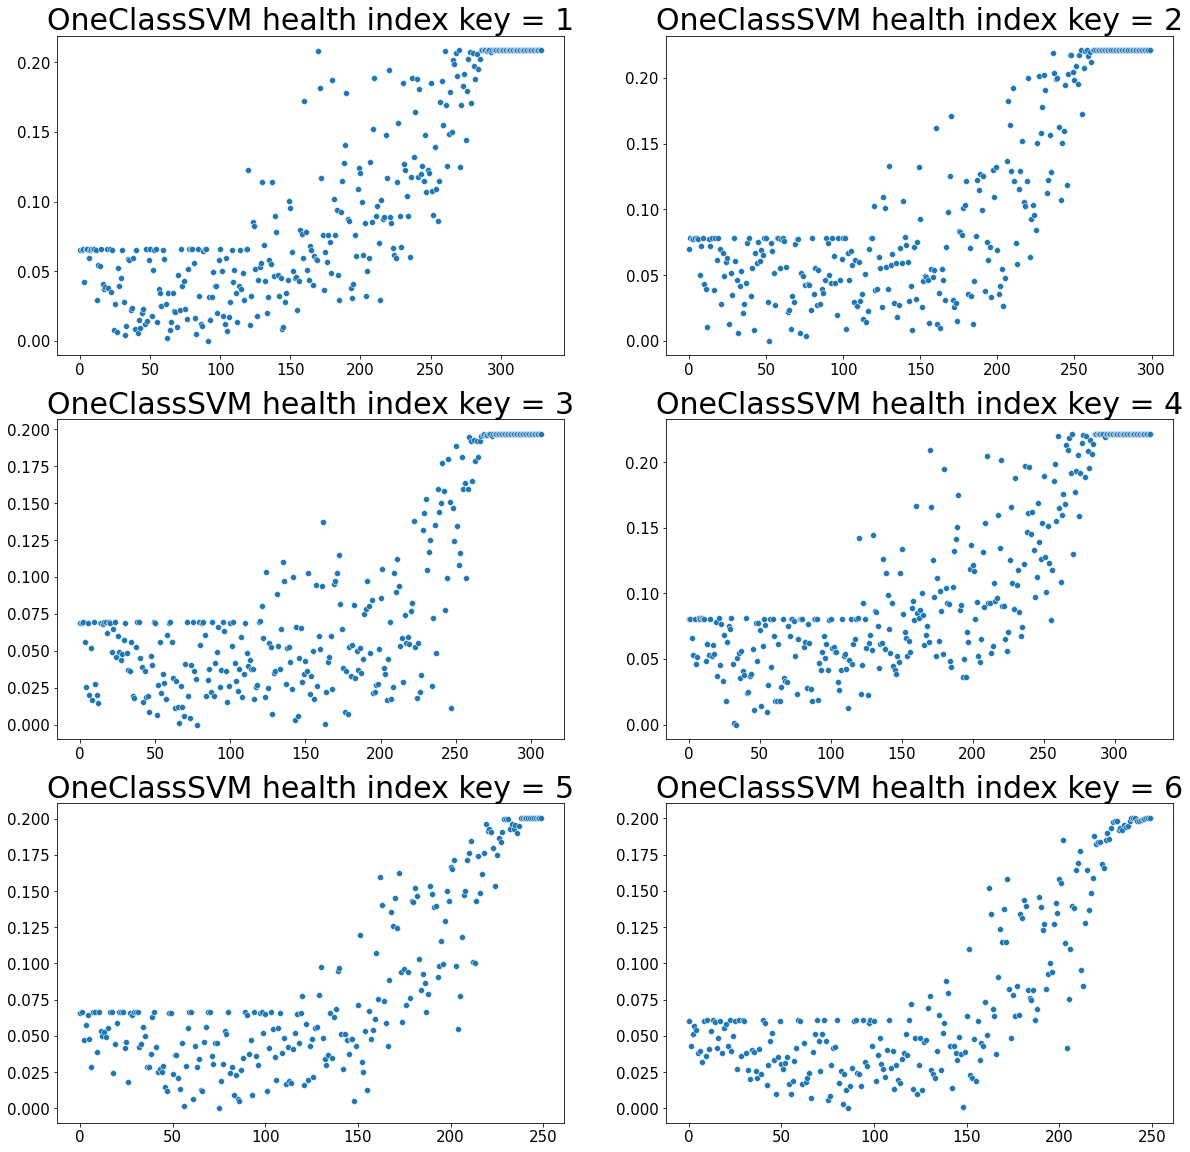

In [20]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

OneClassSVM(nu=0.01)


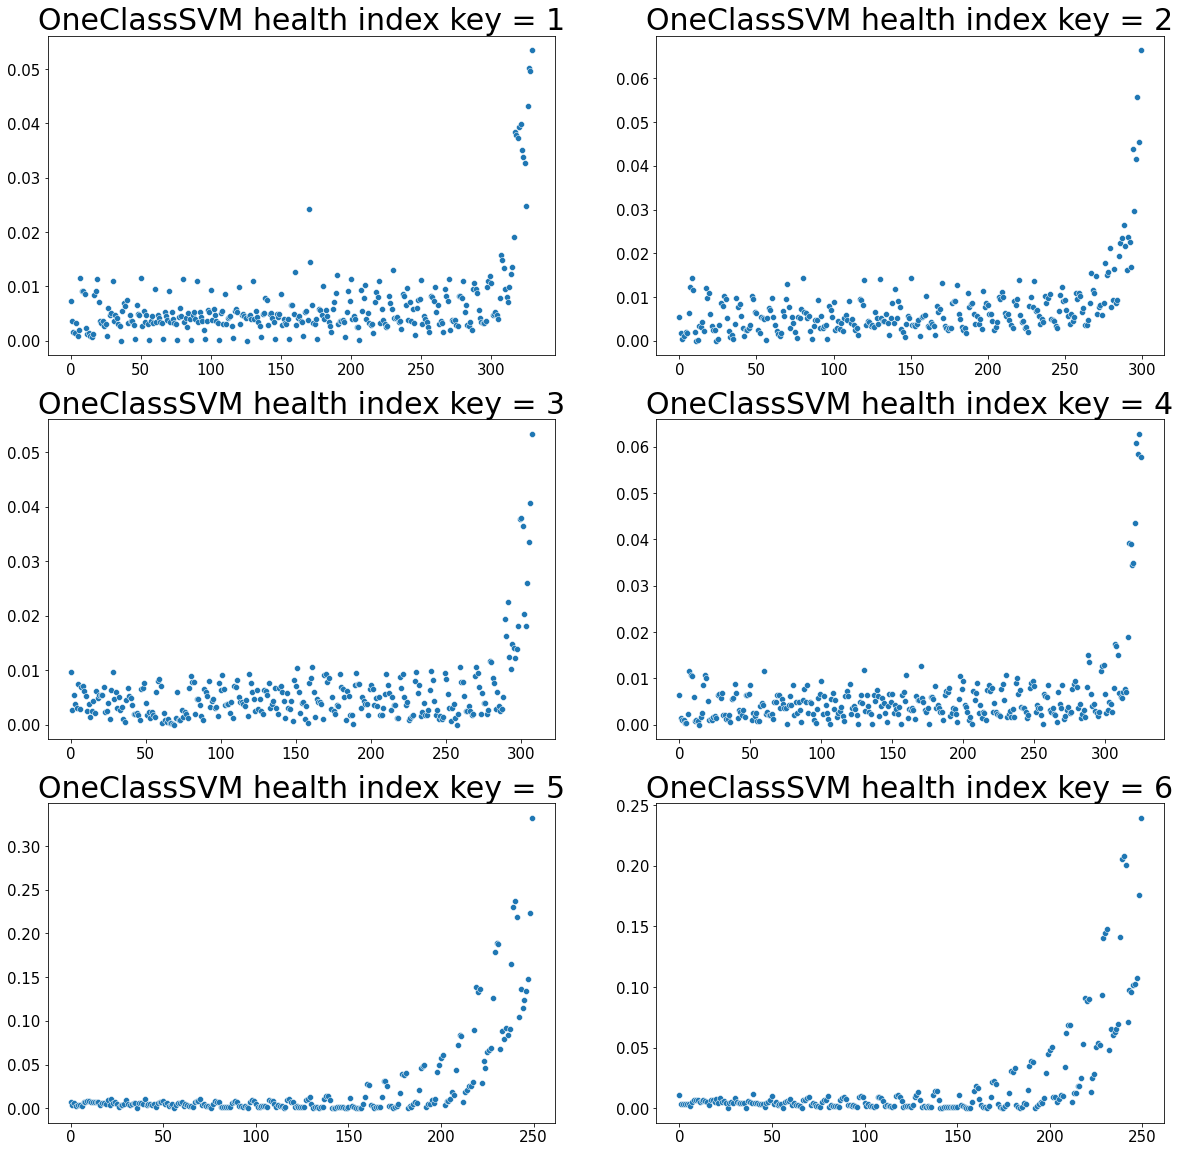

In [21]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'OCSVM', param_dict = {'nu':0.01, 'kernel':'rbf', 'degree': 3})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

> **GMM**

GaussianMixture(n_components=2)


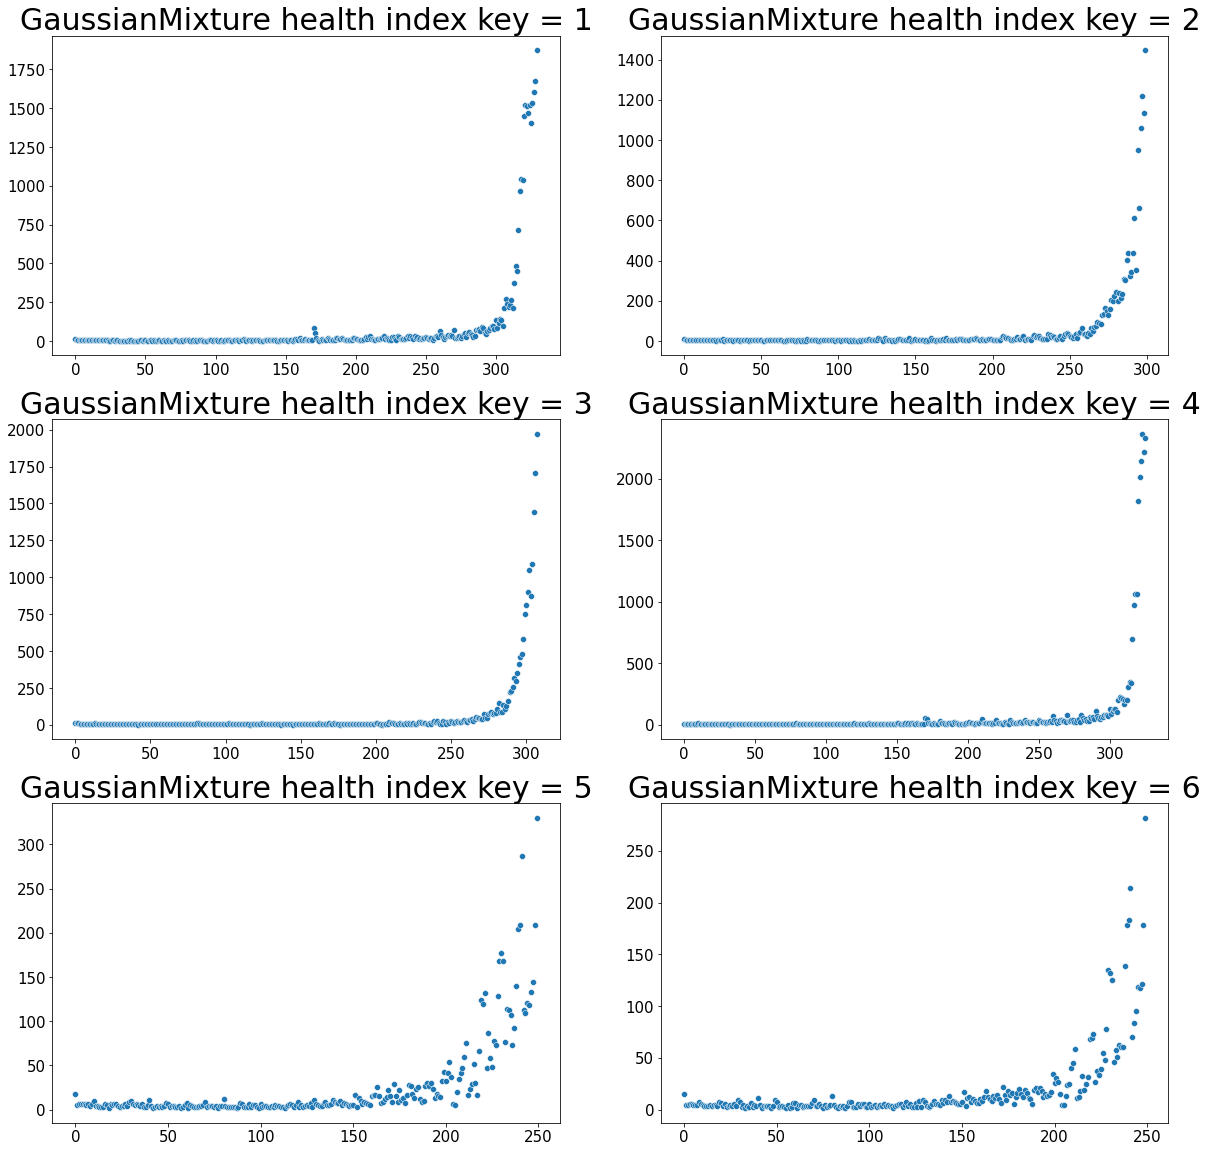

In [22]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components': 2})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

GaussianMixture(n_components=2)


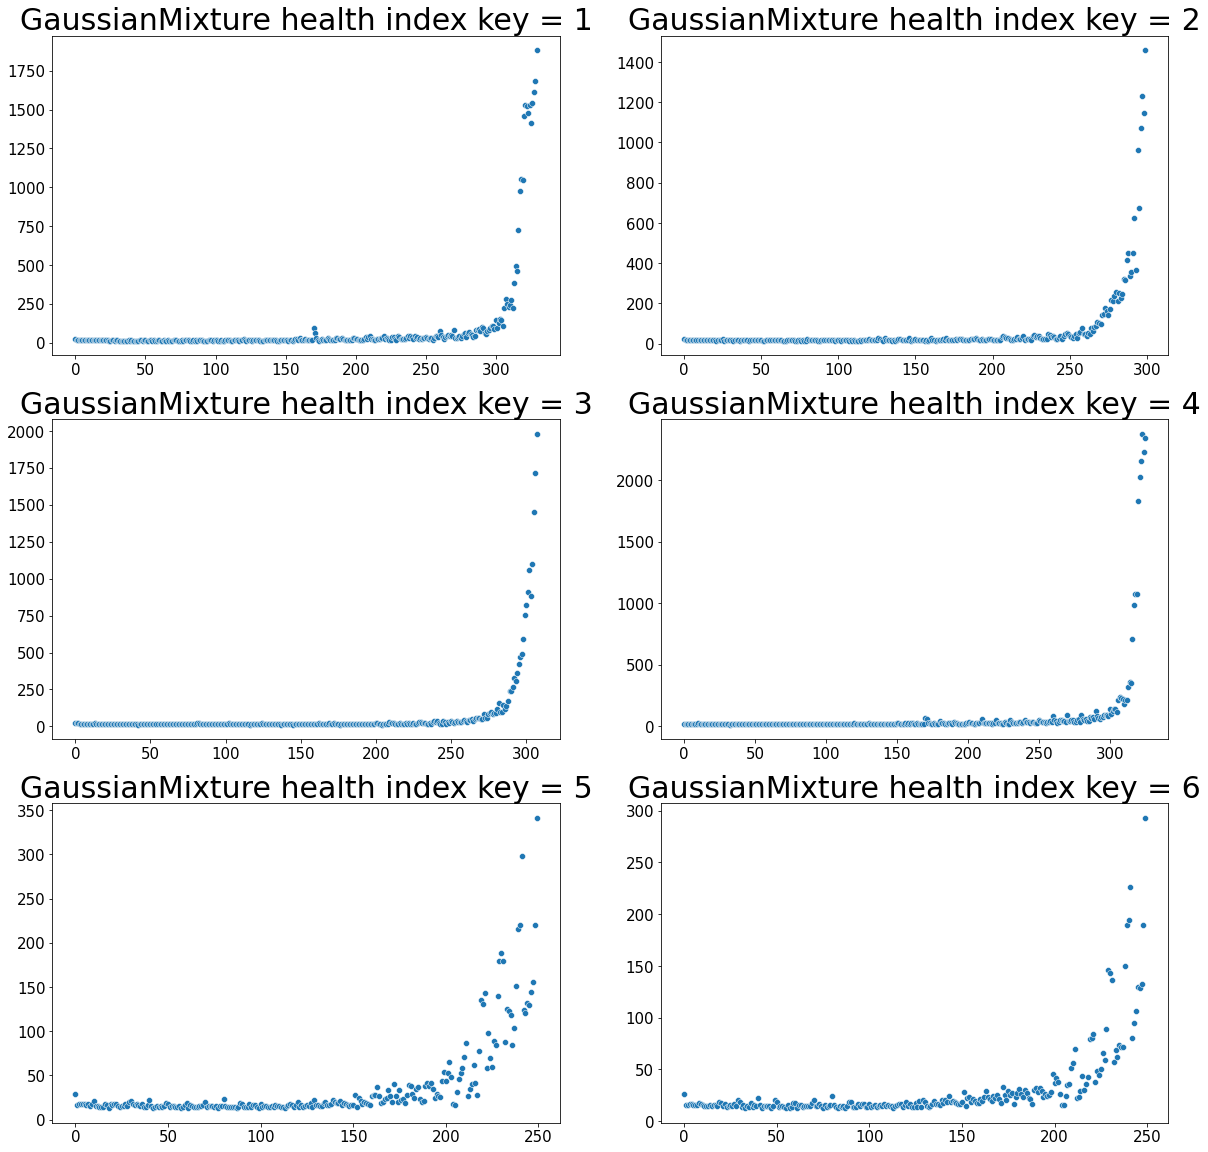

In [23]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components':2, 'covariance_type': 'full'})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

> **AutoEncoder**

Epoch 11: early stopping


NotFittedError: ignored

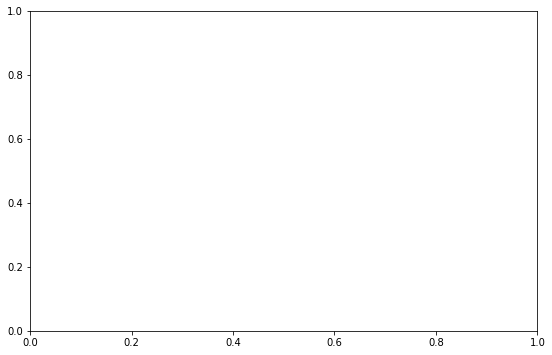

In [24]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'AE')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    #sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)
     

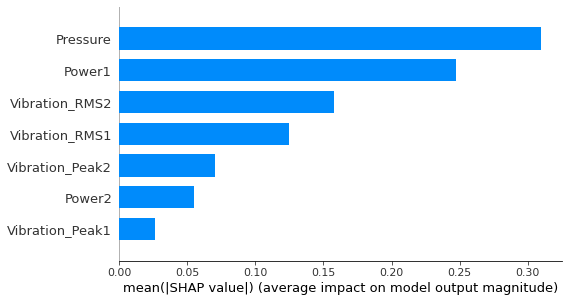

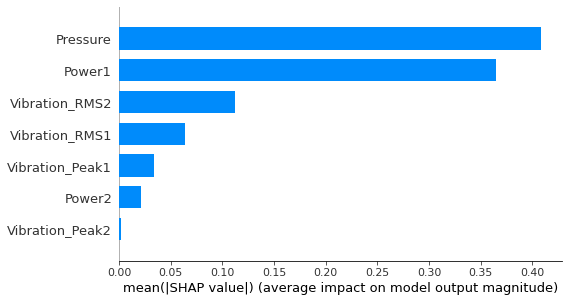

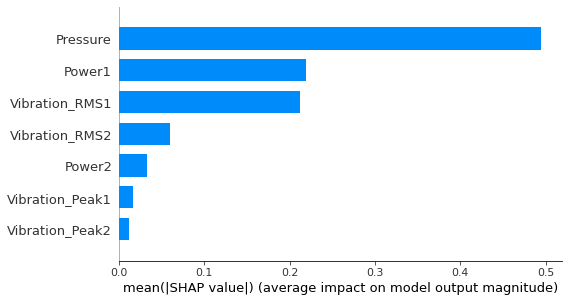

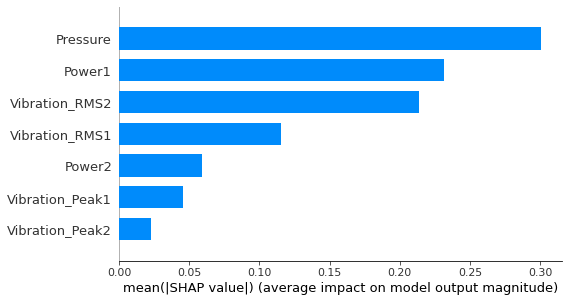

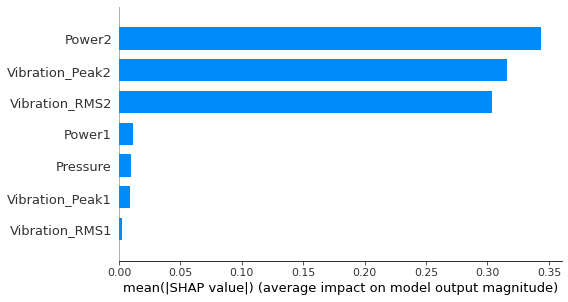

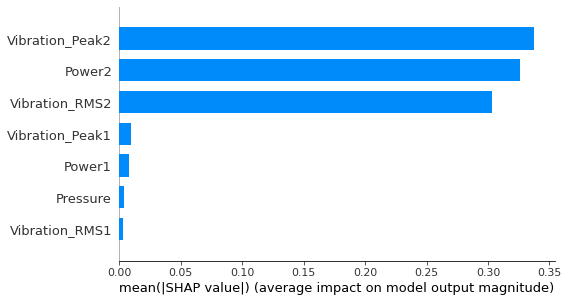

In [25]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'MCD')
  DoXAI(model=model)

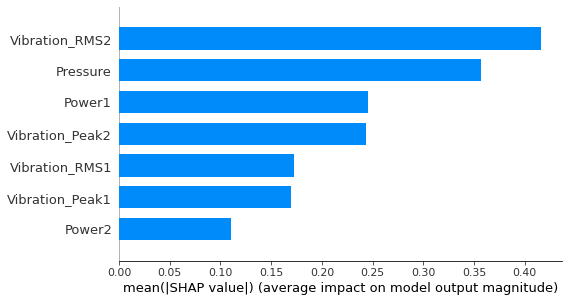

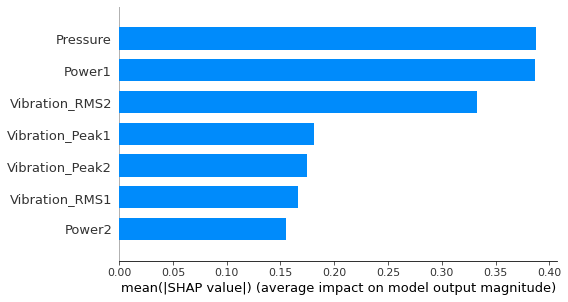

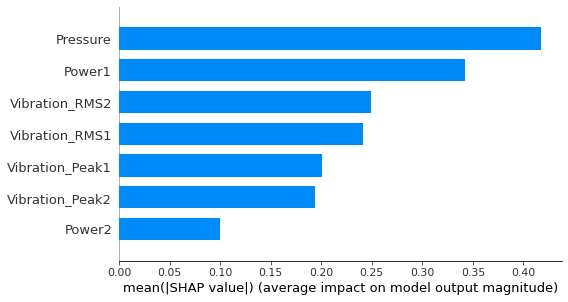

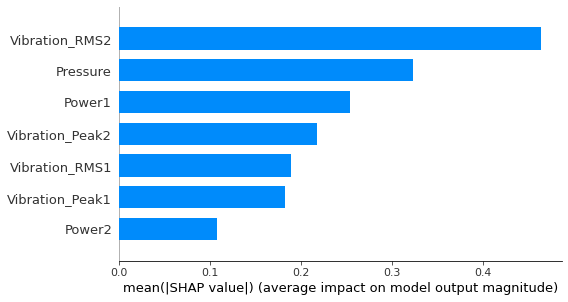

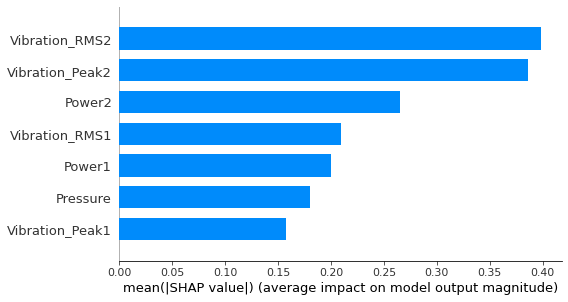

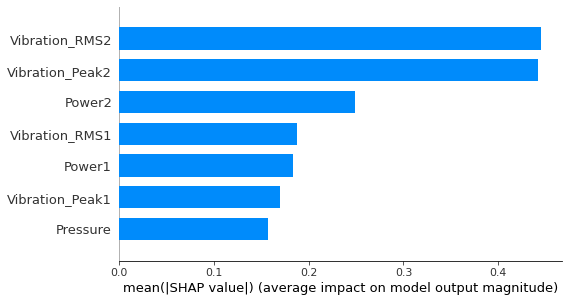

In [26]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'OCSVM')
  DoXAI(model=model)

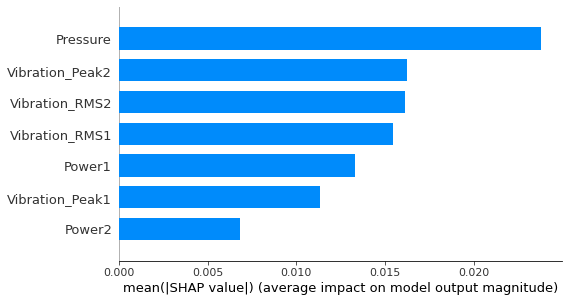

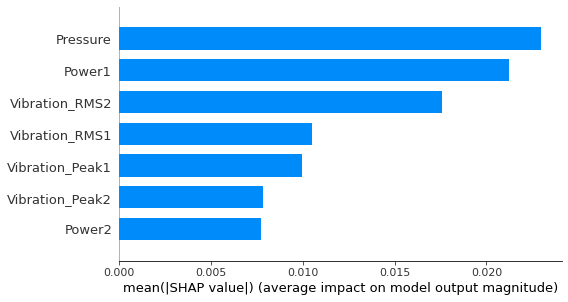

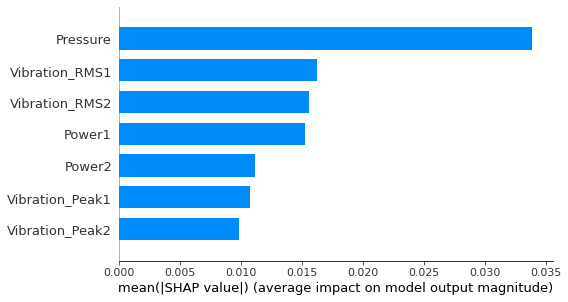

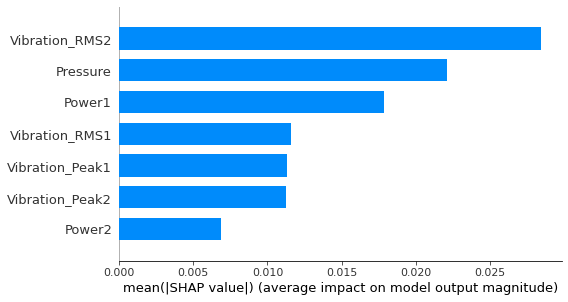

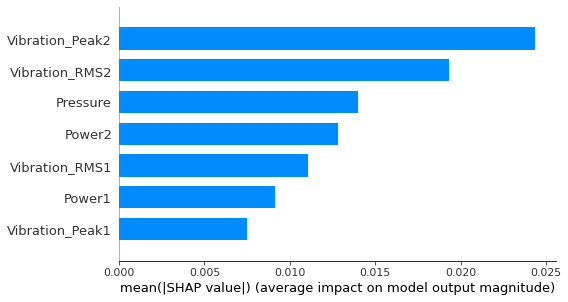

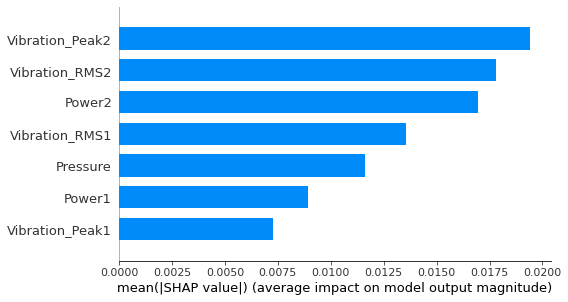

In [27]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'IForest')
  DoXAI(model=model)

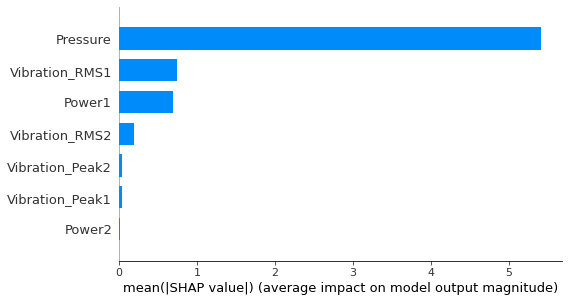

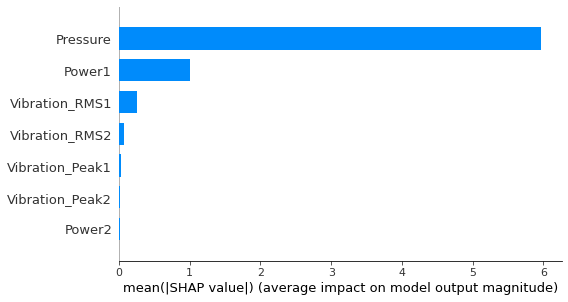

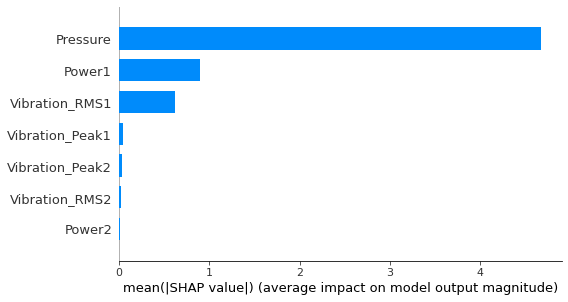

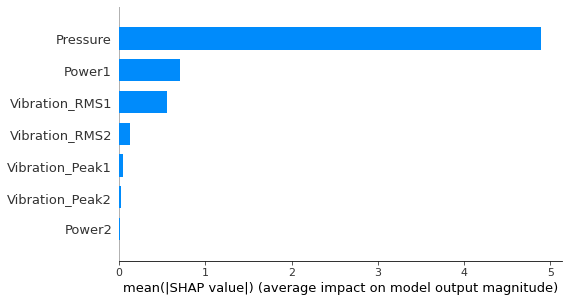

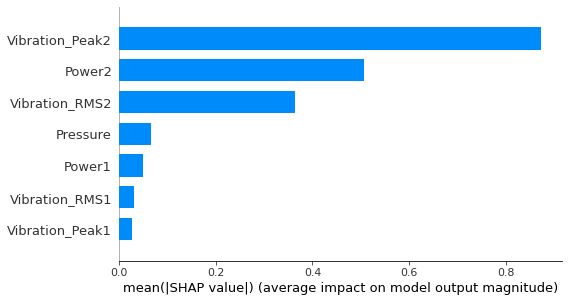

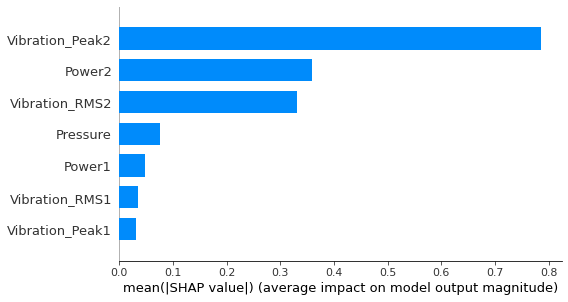

In [28]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'LOF')
  DoXAI(model=model)

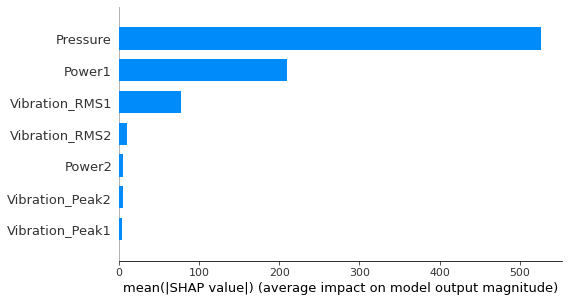

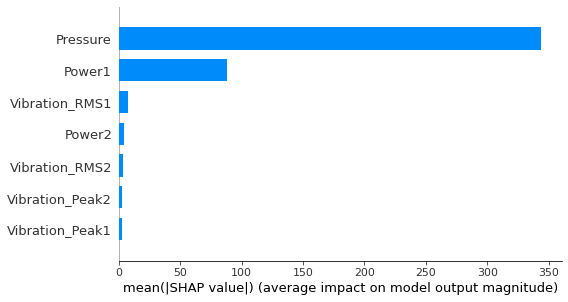

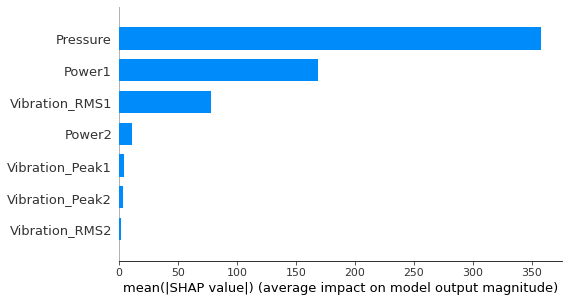

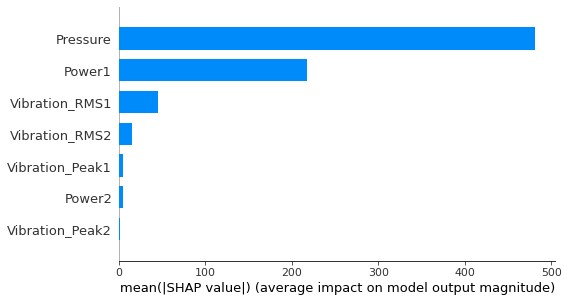

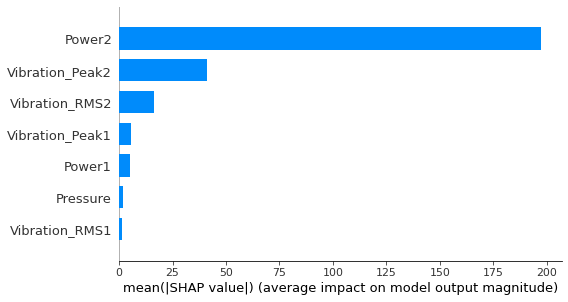

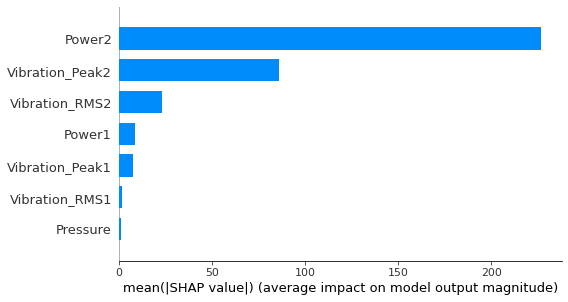

In [29]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'GMM')
  DoXAI(model=model)

In [30]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'AE')
  DoXAI(model=model)

Epoch 11: early stopping


NotFittedError: ignored